# Single server

This example is from Choi, Kang: Modeling and Simulation of Discrete-Event Systems, p. 18. It describes a single server system. The event graph given is:

![single server](../images/sserver.svg)

1. Initially there are no jobs in the queue Q and the machine M is idle.
2. Jobs arrive with an inter-arrival-time t<sub>a</sub> and are added to Q.
3. If M is idle, it loads a job, changes to busy and executes the job with service time t<sub>s</sub>.
4. After that it changes to idle and, if Q is not empty, it loads the next job.

In [1]:
using Sim, Random, Distributions, DataFrames, Plots

In [2]:
abstract type MState end

struct Idle <: MState end
struct Busy <: MState end

mutable struct Job
    no::Int64
    ts::Float64
    t1::Float64
    t2::Float64
    t3::Float64
end

mutable struct Machine
    state::MState
    job
end

Q = Job[]   # input queue
S = Job[]   # stock
M = Machine(Idle(), 0)
df = DataFrame(time = Float64[], buffer=Int[], machine=Int[], finished=Int[])
count = 1
printing = true

stats() = push!(df, (τ(), length(Q), M.state == Busy() ? 1 : 0, length(S)))

stats (generic function with 1 method)

We can model our system activity-based und therefore implement functions for the three main activities. We assume, that the load is equilibrated along $\mu$ and model inter-arrival times $t_a$ with an Erlang and service times $t_s$ with a Normal distribution. 

In [3]:
function arrive(μ)
    @assert μ ≥ 1 "μ must be ≥ 1"
    ts = rand(Normal(μ, μ/5))
    job = Job(count, ts, τ(), 0, 0)
    global count += 1
    push!(Q, job)
    ta = rand(Erlang())*μ
    event!(𝐶, SimFunction(arrive, μ), after, ta)
    printing ? println(τ(), ": job $(job.no) has arrived") : nothing
    stats()
    if M.state == Idle()
        load()
    end
end

function load()
    M.state = Busy()
    M.job = pop!(Q)
    M.job.t2 = τ()
    event!(𝐶, SimFunction(unload), after, M.job.ts)
    printing ? println(τ(), ": job $(M.job.no) has been loaded") : nothing
    stats()
end

function unload()
    M.state = Idle()
    M.job.t3 = τ()
    push!(S, M.job)
    printing ? println(τ(), ": job $(M.job.no) has been finished") : nothing
    stats()
    M.job = 0
    if !isempty(Q)
        load()
    end
end

unload (generic function with 1 method)

We let collect `stats()` at a sample rate of 0.1:  

In [4]:
sample_time!(𝐶, 0.1)
Sim.sample!(𝐶, SimFunction(stats));

We start with one arrival and $\mu = 5$ and let our system run for 30 minutes (let's assume our time unit be minutes):

In [5]:
arrive(5)
run!(𝐶, 30)

0: job 1 has arrived
0: job 1 has been loaded
3.2524083164477755: job 1 has been finished
6.314694504663912: job 2 has arrived
6.314694504663912: job 2 has been loaded
11.65126041220553: job 3 has arrived
12.427408106999277: job 2 has been finished
12.427408106999277: job 3 has been loaded
15.698879958853421: job 3 has been finished
23.299551458893752: job 4 has arrived
23.299551458893752: job 4 has been loaded
27.814278992001974: job 4 has been finished
Finished: 7 events, simulation time: 30.0


Using our collected data, we can plot the simulation model trajectory:

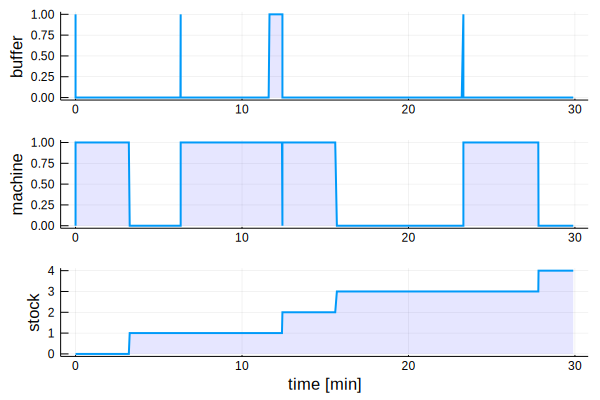

In [6]:
function trajectory_plot()
    p1 = plot(df.time, df.buffer, lw=2, ylabel="buffer", fill=(0,0.1,:blue))
    p2 = plot(df.time, df.machine, lw=2, ylabel="machine", fill=(0,0.1,:blue))
    p3 = plot(df.time, df.finished, lw=2, xlabel="time [min]", ylabel="stock", fill=(0,0.1,:blue))
    plot(p1,p2,p3, layout=(3,1), legend=false)
end
trajectory_plot()

We are interested in the behaviour of our model over a longer time. Therefore we switch off printing and continue the simulation for further 970 "minutes".

In [7]:
printing = false
run!(𝐶, 970)

Finished: 382 events, simulation time: 1000.0


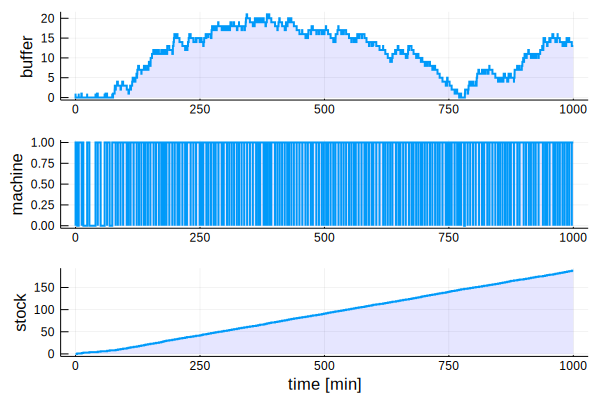

In [8]:
trajectory_plot()

Let's do some stats on it:

In [14]:
function collect_stats()
    buf_mean = mean(df.buffer)
    srv_load = mean(df.machine)
    srv_tim = mean([j.t3-j.t2 for j in S])
    lead_tim = mean([j.t3-j.t1 for j in S])
    (L = buf_mean, W = lead_tim, η = srv_load, ts = srv_tim)
end
collect_stats()

(L = 11.102581072137657, W = 54.98120360678561, η = 0.9462985723740192, ts = 5.104025163357218)

Server load of η ≈ 95% is great, but the mean queue length L > 11 and mean lead time W = 55 min are way too long for a service time of ts ≈ 5. So let's analyze the dependency of mean queue length L on server utilization η.